# Biosignal processing


#### Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import pickle

In [26]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import systole
import plotly
import peakdet
import heartpy as hp

In [4]:
%pylab inline
sns.set_style('darkgrid')
pylab.rcParams['figure.figsize'] = (12.0, 6.0)  
plt.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


#### Import home functions

In [5]:
%run ~/cneuromod/ds_prep/physio/preproc/neuromod_process.py

#### Fetch data

In [6]:
filename = "/scratch/flesp/physio_data/friends/sub-03/ses-003/sub-03_ses-003_task-s01e05a_physio"

In [7]:
filename[filename.rfind('/')+1:]

'sub-03_ses-003_task-s01e05a_physio'

In [8]:
json=pd.read_json(f"{filename}.json")

In [9]:
fs = json['SamplingFrequency'][0]

In [10]:
bio_df = pd.read_csv(f"{filename}.tsv.gz",
                     sep='\t',
                     compression='gzip',
                     header=None,
                     names=json.Columns)

#### Visualize low-level processing

In [11]:
signal = bio_df['time']
downsampled_interpolation = nk.signal_resample(signal, method="interpolation",
                                               sampling_rate=10000,desired_sampling_rate=1000)

In [12]:
sig = nk.signal_filter(bio_df['PPG'], fs, lowcut=0.5, highcut=8, order=3)
detrend = nk.signal_detrend(bio_df['PPG'], order=2 )

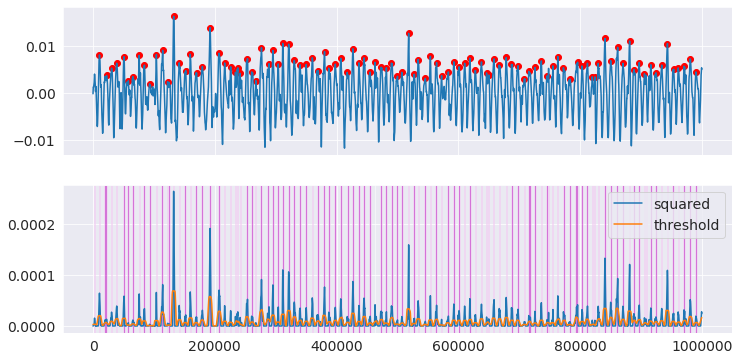

In [13]:
info = nk.ppg_findpeaks(sig[2500000:3500000], fs, show=True)

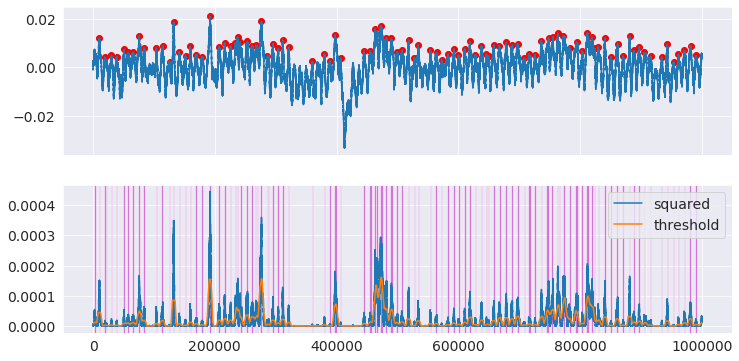

In [14]:
info = nk.ppg_findpeaks(detrend[2500000:3500000], fs, show=True)

#### Visualize high-level workflow

In [15]:
wd, m = hp.process(sig, fs)

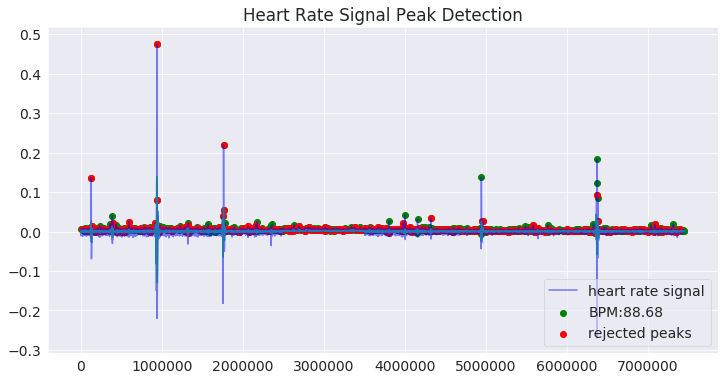

In [16]:
hp.plotter(wd, m, show=True)

In [17]:
m

{'bpm': 88.68265016756897,
 'ibi': 676.5697674418604,
 'sdnn': 195.05810378816432,
 'sdsd': 156.19475941873242,
 'rmssd': 250.26354792436138,
 'pnn20': 0.9326424870466321,
 'pnn50': 0.7979274611398963,
 'hr_mad': 165.59999999999997,
 'breathingrate': nan}

In [18]:
wd.keys()

dict_keys(['hr', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'peaklist_cor', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50'])

#### Processing functions for neuromod PPG

In [19]:
signals, info_corrected = neuromod_ppg_process(bio_df['PPG'], fs)

PPG Cleaned
HeartPy processing started

Finished in 38.06843 sec
Heartpy found peaks
Neurokit found peaks
Cleaning the RR interval time series using 4 iterations.
 - Iteration 1 - 
... correcting 7 missed interval(s).
... correcting 29 ectopic interval(s).
... correcting 1 short interval(s).
 - Iteration 2 - 
... correcting 4 missed interval(s).
... correcting 3 extra interval(s).
... correcting 10 ectopic interval(s).
 - Iteration 3 - 
... correcting 2 missed interval(s).
... correcting 1 extra interval(s).
... correcting 8 ectopic interval(s).
 - Iteration 4 - 
... correcting 2 missed interval(s).
... correcting 2 ectopic interval(s).
Cleaning the peaks vector using 4 iterations.
 - Iteration 1 - 
... correcting 1 extra peak(s).
... correcting 6 missed peak(s).
 - Iteration 2 - 
... correcting 2 missed peak(s).
 - Iteration 3 - 
 - Iteration 4 - 
systole corrected RR series


In [20]:
signals.head()

,PPG_Raw,PPG_Clean,PPG_Peaks_NK,PPG_Peaks_HP,PPG_Peaks_Systole,PPG_Rate
0,-0.014343,0.00253,0.0,0.0,False,61.55213
1,-0.014343,0.00253,0.0,0.0,False,61.55213
2,-0.014343,0.00253,0.0,0.0,False,61.55213
3,-0.014648,0.00253,0.0,0.0,False,61.55213
4,-0.014954,0.00253,0.0,0.0,False,61.55213


In [21]:
info_corrected.keys()

dict_keys(['PPG_Peaks', 'PPG_ectopic', 'PPG_short', 'PPG_clean_rr_systole', 'PPG_clean_rr_hp', 'PPG_long', 'PPG_extra', 'PPG_missed', 'PPG_rejected_segments', 'PPG_Peaks_corrected', 'PPG_cumulseconds_rejected', 'PPG_%_rejected_segments'])

#### Interactive visualization

In [23]:
plot = systole.plots.plot_raw(signals['PPG_Clean'], backend='bokeh', show_heart_rate=True, show_artefacts=True, sfreq=fs)

In [24]:
from bokeh.io import output_notebook
from bokeh.plotting import show, output_file, save
output_notebook()

show(plot)

Loading BokehJS ...

In [26]:
plot_rr = systole.plots.plot_rr(info_corrected['PPG_clean_rr_systole'],input_type='rr_ms',backend='bokeh', show_artefacts=True)

In [27]:
output_notebook()

show(plot_rr)

Loading BokehJS ...

### High-level main function for all biosignals

In [31]:
bio_proc, bio_info = neuromod_bio_process(df=bio_df, sampling_rate=fs)

Reading pandas DataFrame
PPG Cleaned
HeartPy processing started

Finished in 29.81099 sec
Heartpy found peaks
Neurokit found peaks
Cleaning the RR interval time series using 4 iterations.
 - Iteration 1 - 
... correcting 7 missed interval(s).
... correcting 29 ectopic interval(s).
... correcting 1 short interval(s).
 - Iteration 2 - 
... correcting 4 missed interval(s).
... correcting 3 extra interval(s).
... correcting 10 ectopic interval(s).
 - Iteration 3 - 
... correcting 2 missed interval(s).
... correcting 1 extra interval(s).
... correcting 8 ectopic interval(s).
 - Iteration 4 - 
... correcting 2 missed interval(s).
... correcting 2 ectopic interval(s).
Cleaning the peaks vector using 4 iterations.
 - Iteration 1 - 
... correcting 1 extra peak(s).
... correcting 6 missed peak(s).
 - Iteration 2 - 
... correcting 2 missed peak(s).
 - Iteration 3 - 
 - Iteration 4 - 
systole corrected RR series
Respiration workflow: done
Electrodermal activity workflow: done


In [32]:
bio_proc.keys()

Index(['PPG_Raw', 'PPG_Clean', 'PPG_Peaks_NK', 'PPG_Peaks_HP',
       'PPG_Peaks_Systole', 'PPG_Rate', 'ECG', 'RSP_Raw', 'RSP_Clean',
       'RSP_Amplitude', 'RSP_Rate', 'RSP_Phase', 'RSP_Phase_Completion',
       'RSP_Peaks', 'RSP_Troughs', 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic',
       'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime', 'TTL', 'time'],
      dtype='object')

In [33]:
bio_info.keys()

dict_keys(['PPG_Peaks', 'PPG_ectopic', 'PPG_short', 'PPG_clean_rr_systole', 'PPG_clean_rr_hp', 'PPG_long', 'PPG_extra', 'PPG_missed', 'PPG_rejected_segments', 'PPG_Peaks_corrected', 'PPG_cumulseconds_rejected', 'PPG_%_rejected_segments', 'RSP_Peaks', 'RSP_Troughs', 'sampling_rate', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'])

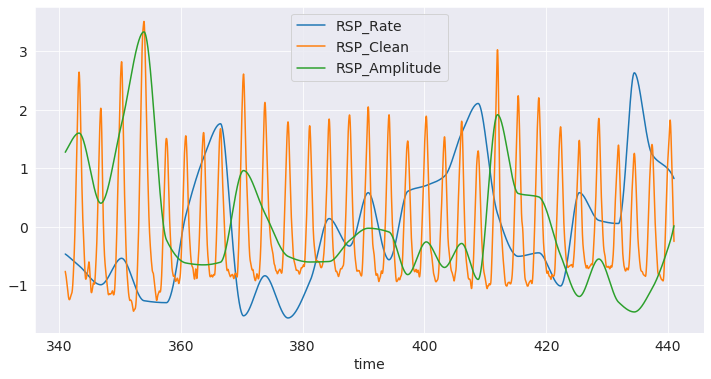

In [42]:
df1 = nk.standardize(bio_proc[['RSP_Rate', 'RSP_Clean','RSP_Amplitude']][3500000:4500000])
df1['time'] = bio_proc['time'][3500000:4500000]
df1.plot(x='time')

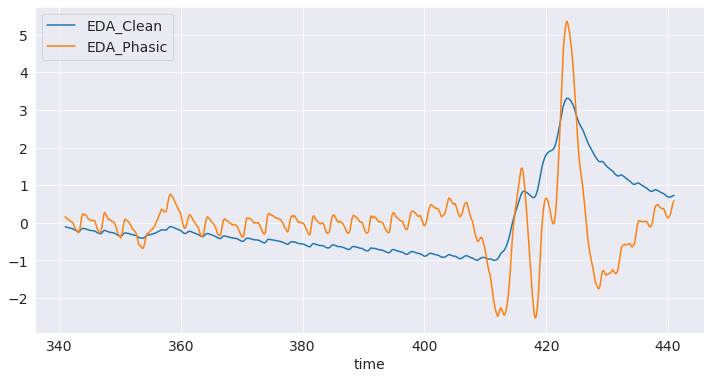

In [43]:
df1 = nk.standardize(bio_proc[['EDA_Clean', 'EDA_Phasic']][3500000:4500000])
df1['time'] = bio_proc['time'][3500000:4500000]
df1.plot(x='time')

In [98]:
indir = "/scratch/flesp/physio_data/friends/viz/"
sub=['sub-01', 'sub-02','sub-03', 'sub-04','sub-05', 'sub-06']
sessions=['ses-001','ses-002','ses-003','ses-004','ses-005','ses-006','ses-007','ses-008',
          'ses-009','ses-010','ses-011','ses-012','ses-013','ses-014','ses-015','ses-016','ses-017',
          'ses-018','ses-019','ses-020',]
res={}
for s in sub:
    print(s)
    print("~"*30)
    print("~"*30)
    res[s]=[]
    for ses in sessions:
        print(f"Currently processing {ses}")
        
        json = glob.glob(f"{indir}{s}/{ses}/*.json")
        
        json.sort()
        for i, info in enumerate(json):
            with open(info, 'rb') as f:
                tmp = pickle.load(f)
            print(f"{ses} run {i+1}")
            print("-"*30)
            try:
                print("Ectopic",tmp['PPG_ectopic'])
            except KeyError:
                continue
            if np.mean(tmp['PPG_clean_rr_hp']) != :
                res[s].append(round(np.mean(tmp['PPG_clean_rr_hp']), 3))
            print("mean IBI - Systole", round(tmp['PPG_clean_rr_systole'].mean(), 3))
            print("mean IBI - HeartPy", round(np.mean(tmp['PPG_clean_rr_hp']), 3))
            print("Short",tmp['PPG_short'])
            print("Extra",tmp['PPG_extra'])
            print("Long",tmp['PPG_long'])
            print("Missed",tmp['PPG_missed'])
            print("Percentage of rejected",round(tmp['PPG_%_rejected_segments']*100, 3))
            
            

sub-01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently processing ses-001
ses-001 run 1
------------------------------
Ectopic 4
mean IBI - Systole 859.518
mean IBI - HeartPy 854.901
Short 2
Extra 0
Long 0
Missed 0
Percentage of rejected 1.494
ses-001 run 2
------------------------------
Ectopic 0
mean IBI - Systole 874.677
mean IBI - HeartPy 865.252
Short 0
Extra 0
Long 3
Missed 0
Percentage of rejected 3.26
ses-001 run 3
------------------------------
Ectopic 6
mean IBI - Systole 908.929
mean IBI - HeartPy 892.144
Short 0
Extra 0
Long 0
Missed 0
Percentage of rejected 9.428
ses-001 run 4
------------------------------
Ectopic 7
mean IBI - Systole 901.576
mean IBI - HeartPy 885.944
Short 1
Extra 0
Long 0
Missed 0
Percentage of rejected 9.844
Currently processing ses-002
ses-002 run 1
------------------------------
Ectopic 0
mean IBI - Systole 892.484
mean IBI - HeartPy 877.298
Short 1
Extra 0
Long 0
Missed 0
Percentage of rejected 6.776
ses-002 run 2
----------

ses-018 run 1
------------------------------
Ectopic 25
mean IBI - Systole 760.146
mean IBI - HeartPy 713.256
Short 1
Extra 0
Long 17
Missed 6
Percentage of rejected 15.057
ses-018 run 2
------------------------------
Ectopic 12
mean IBI - Systole 797.889
mean IBI - HeartPy 797.406
Short 0
Extra 0
Long 0
Missed 0
Percentage of rejected 0.0
ses-018 run 3
------------------------------
Ectopic 19
mean IBI - Systole 793.28
mean IBI - HeartPy 792.901
Short 0
Extra 0
Long 0
Missed 0
Percentage of rejected 0.0
Currently processing ses-019
ses-019 run 1
------------------------------
Ectopic 12
mean IBI - Systole 864.165
mean IBI - HeartPy 799.037
Short 4
Extra 1
Long 23
Missed 19
Percentage of rejected 21.986
ses-019 run 2
------------------------------
Ectopic 0
mean IBI - Systole 868.251
mean IBI - HeartPy 851.826
Short 0
Extra 0
Long 8
Missed 0
Percentage of rejected 2.535
ses-019 run 3
------------------------------
Ectopic 8
mean IBI - Systole 878.692
mean IBI - HeartPy 858.525
Short 2


ses-016 run 5
------------------------------
Ectopic 100
mean IBI - Systole 762.823
mean IBI - HeartPy 412.455
Short 1
Extra 5
Long 0
Missed 20
Percentage of rejected 17.176
Currently processing ses-017
Currently processing ses-018
ses-018 run 1
------------------------------
Ectopic 0
mean IBI - Systole 3009.492
mean IBI - HeartPy 690.454
Short 0
Extra 0
Long 4
Missed 0
Percentage of rejected 19.17
ses-018 run 2
------------------------------
Ectopic 59
mean IBI - Systole 761.553
mean IBI - HeartPy 285.691
Short 1
Extra 0
Long 0
Missed 33
Percentage of rejected 12.407
Currently processing ses-019
ses-019 run 1
------------------------------
Ectopic 0
mean IBI - Systole 1098.672
mean IBI - HeartPy 600.808
Short 0
Extra 0
Long 1
Missed 1
Percentage of rejected 24.481
ses-019 run 2
------------------------------
Ectopic 61
mean IBI - Systole 704.289
mean IBI - HeartPy 392.055
Short 0
Extra 2
Long 0
Missed 8
Percentage of rejected 21.511
ses-019 run 3
------------------------------
Ectopi

ses-015 run 5
------------------------------
Ectopic 80
mean IBI - Systole 861.848
mean IBI - HeartPy 857.466
Short 6
Extra 1
Long 1
Missed 1
Percentage of rejected 0.72
ses-015 run 6
------------------------------
Ectopic 42
mean IBI - Systole 851.778
mean IBI - HeartPy 852.516
Short 4
Extra 5
Long 0
Missed 4
Percentage of rejected 3.312
ses-015 run 7
------------------------------
Ectopic 0
mean IBI - Systole 885.604
mean IBI - HeartPy 533.773
Short 0
Extra 0
Long 0
Missed 0
Percentage of rejected 35.603
ses-015 run 8
------------------------------
Ectopic 63
mean IBI - Systole 895.45
mean IBI - HeartPy 877.357
Short 4
Extra 8
Long 8
Missed 6
Percentage of rejected 12.549
ses-015 run 9
------------------------------
Ectopic 2
mean IBI - Systole 21850.968
mean IBI - HeartPy 804.83
Short 0
Extra 0
Long 0
Missed 1
Percentage of rejected 11.756
Currently processing ses-016
ses-016 run 1
------------------------------
Ectopic 3
mean IBI - Systole 1426.755
mean IBI - HeartPy 792.729
Short 

ses-011 run 3
------------------------------
Ectopic 42
mean IBI - Systole 927.143
mean IBI - HeartPy 828.454
Short 1
Extra 5
Long 0
Missed 0
Percentage of rejected 47.635
ses-011 run 4
------------------------------
Ectopic 63
mean IBI - Systole 942.053
mean IBI - HeartPy 652.464
Short 8
Extra 8
Long 1
Missed 0
Percentage of rejected 77.296
ses-011 run 5
------------------------------
Ectopic 0
mean IBI - Systole 1004.162
mean IBI - HeartPy nan
Short 0
Extra 0
Long 0
Missed 0
Percentage of rejected 71.206
ses-011 run 6
------------------------------
Ectopic 20
mean IBI - Systole 993.003
mean IBI - HeartPy 884.513
Short 0
Extra 0
Long 1
Missed 0
Percentage of rejected 88.055
ses-011 run 7
------------------------------
Ectopic 87
mean IBI - Systole 971.898
mean IBI - HeartPy 822.19
Short 4
Extra 10
Long 2
Missed 4
Percentage of rejected 82.766
ses-011 run 8
------------------------------
Ectopic 67
mean IBI - Systole 969.108
mean IBI - HeartPy 706.428
Short 5
Extra 15
Long 1
Missed 8
P

ses-005 run 3
------------------------------
Ectopic 57
mean IBI - Systole 879.798
mean IBI - HeartPy 855.173
Short 5
Extra 0
Long 6
Missed 1
Percentage of rejected 19.477
ses-005 run 4
------------------------------
Ectopic 32
mean IBI - Systole 916.636
mean IBI - HeartPy 597.2
Short 2
Extra 3
Long 2
Missed 2
Percentage of rejected 86.011
ses-005 run 5
------------------------------
Ectopic 57
mean IBI - Systole 904.785
mean IBI - HeartPy 816.105
Short 8
Extra 1
Long 6
Missed 6
Percentage of rejected 46.346
ses-005 run 6
------------------------------
Ectopic 28
mean IBI - Systole 917.462
mean IBI - HeartPy 725.998
Short 4
Extra 0
Long 8
Missed 10
Percentage of rejected 70.23
ses-005 run 7
------------------------------
Ectopic 30
mean IBI - Systole 929.382
mean IBI - HeartPy 919.702
Short 6
Extra 2
Long 6
Missed 6
Percentage of rejected 17.428
ses-005 run 8
------------------------------
Ectopic 38
mean IBI - Systole 928.313
mean IBI - HeartPy 916.358
Short 4
Extra 1
Long 5
Missed 0


mean IBI - HeartPy 448.073
Short 3
Extra 12
Long 4
Missed 1
Percentage of rejected 82.751
ses-015 run 3
------------------------------
Ectopic 68
mean IBI - Systole 932.623
mean IBI - HeartPy 400.777
Short 9
Extra 22
Long 2
Missed 4
Percentage of rejected 52.583
ses-015 run 4
------------------------------
Ectopic 87
mean IBI - Systole 922.139
mean IBI - HeartPy 456.177
Short 6
Extra 26
Long 4
Missed 12
Percentage of rejected 59.095
ses-015 run 5
------------------------------
Ectopic 86
mean IBI - Systole 927.21
mean IBI - HeartPy 406.87
Short 15
Extra 25
Long 1
Missed 8
Percentage of rejected 52.299
Currently processing ses-016
ses-016 run 1
------------------------------
Ectopic 3
mean IBI - Systole 1400.206
mean IBI - HeartPy 762.886
Short 0
Extra 0
Long 0
Missed 1
Percentage of rejected 29.52
ses-016 run 2
------------------------------
Ectopic 6
mean IBI - Systole 882.47
mean IBI - HeartPy 880.286
Short 4
Extra 0
Long 6
Missed 0
Percentage of rejected 0.857
ses-016 run 3
--------

ses-003 run 10
------------------------------
Ectopic 12
mean IBI - Systole 976.283
mean IBI - HeartPy 336.346
Short 0
Extra 0
Long 0
Missed 4
Percentage of rejected 31.026
ses-003 run 11
------------------------------
Ectopic 0
mean IBI - Systole 1003.776
mean IBI - HeartPy nan
Short 1
Extra 0
Long 0
Missed 0
Percentage of rejected 75.656
ses-003 run 12
------------------------------
Ectopic 16
mean IBI - Systole 983.477
mean IBI - HeartPy 715.122
Short 4
Extra 0
Long 1
Missed 6
Percentage of rejected 89.782
ses-003 run 13
------------------------------
Ectopic 8
mean IBI - Systole 961.706
mean IBI - HeartPy 555.588
Short 5
Extra 0
Long 0
Missed 1
Percentage of rejected 86.18
Currently processing ses-004
Currently processing ses-005
ses-005 run 1
------------------------------
Ectopic 0
mean IBI - Systole 790.327
mean IBI - HeartPy 719.708
Short 0
Extra 0
Long 2
Missed 0
Percentage of rejected 39.02
ses-005 run 2
------------------------------
Ectopic 10
mean IBI - Systole 954.12
mean

In [99]:
res.keys()

dict_keys(['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06'])

In [100]:
for i in res.values():
    print(np.mean(i))

817.2378617021276
524.6716527777777
755.6159239130436
nan
nan
nan


In [7]:
results=pd.DataFrame.from_dict(res, orient='index')
results = results.T
results.replace(0, np.nan)

,sub-01,sub-02,sub-03,sub-04,sub-05,sub-06
0,NaN,8.0,25.0,NaN,3.0,7.0
1,NaN,13.0,10.0,NaN,NaN,NaN
2,NaN,15.0,6.0,4.0,1.0,NaN
3,NaN,22.0,11.0,1.0,2.0,NaN
4,NaN,24.0,10.0,8.0,NaN,NaN
...,...,...,...,...,...,...
167,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN
169,NaN,NaN,NaN,NaN,4.0,NaN
170,NaN,NaN,NaN,NaN,10.0,NaN


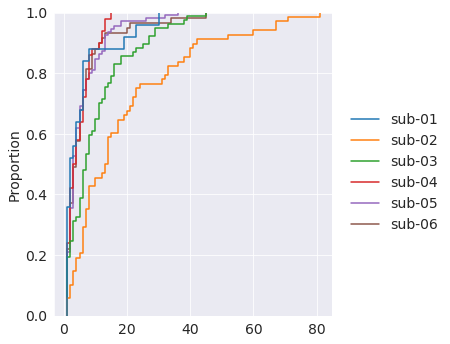

In [8]:
sns.displot(data=results.replace(0, np.nan), kind='ecdf')

In [78]:
results.describe()

,sub-01,sub-02,sub-03,sub-04,sub-05,sub-06
count,94.000000,72.000000,92.000000,109.000000,172.000000,97.000000
mean,1.457447,17.861111,8.434783,2.155963,3.534884,3.577320
std,4.507258,18.788898,9.875382,3.491191,5.520187,6.645542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.750000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,12.500000,6.000000,0.000000,2.000000,1.000000
75%,1.000000,23.000000,11.250000,3.000000,4.000000,5.000000
max,30.000000,81.000000,45.000000,15.000000,36.000000,45.000000
